### DataCamp project link: [Clustering Antarctic Penguin Species](https://app.datacamp.com/learn/projects/1809)
by match1

The dataset is available in the data folder as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

<i>Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  The task is to help them identify groups in the dataset.<i>

### Import Required Packages

In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Load the dataset

In [407]:
# Load Dataset
penguins_df = pd.read_csv("../data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


In [408]:
penguins_df.shape

(332, 5)

In [409]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [410]:
penguins_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


In [411]:
penguins_df['sex'].value_counts()

sex
MALE      167
FEMALE    165
Name: count, dtype: int64

## Data Preprocessing

#### Check for missing values

In [412]:
penguins_df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

#### Check for outliers
Outliers can distort the clustering process, especially with algorithms like K-means which rely on distance metrics.

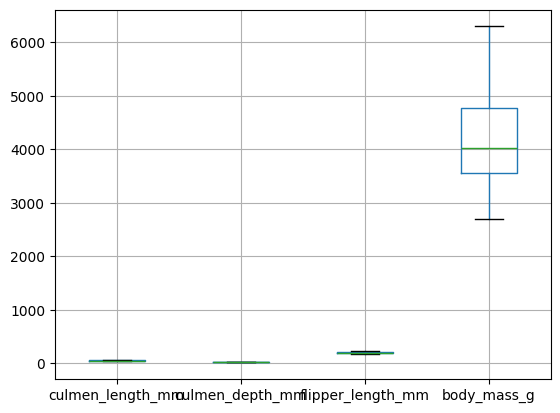

In [413]:
penguins_df.boxplot()  
plt.show()

There are no outliers in this dataset

#### Create dummy variables for the sex column
`pd.get_dummies()` converts categorical data into dummy or indicator variables. This way, we get female & male sex columns.

In [414]:
new_penguins_df = pd.get_dummies(penguins_df, dtype=int)
new_penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
3,36.7,19.3,193.0,3450.0,1,0
4,39.3,20.6,190.0,3650.0,0,1


#### Scale the data using StandardScaler

**K-means clustering** is based on Euclidean distance (the distance between points is computed using the sum of squared differences between their feature values). Standardization scales the features to have zero mean and unit variance, which ensures that all features contribute equally to the distance calculation. This can lead to more balanced clusters and better clustering results.

In [415]:
# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_penguins_df)

# Get the original column names
column_names = new_penguins_df.columns

# Convert back to DataFrame and keep original column names
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.903906,0.790360,-1.425342,-0.566948,-0.993994,0.993994
1,-0.830434,0.126187,-1.068577,-0.504847,1.006042,-1.006042
2,-0.683490,0.432728,-0.426399,-1.187953,1.006042,-1.006042
3,-1.344738,1.096901,-0.569105,-0.939551,1.006042,-1.006042
4,-0.867170,1.761074,-0.783164,-0.691149,-0.993994,0.993994


### Dimensionality Reduction using PCA

- PCA aims to reduce the number of dimensions (features) while retaining the most variance (information) from the original data.
- By selecting components that explain a significant portion of the variance, PCA ensures that the reduced dataset still captures the essential structure and patterns.

In [416]:
# Initial PCA run (PCA will consider all possible components)
pca = PCA() 
df1_pca = pca.fit(scaled_df)

# Get Explained variance. It measures how much of the total variance in the data is captured by each principal component.
df1_pca.explained_variance_ratio_

# Determine number of components with more than 10% explained variance ratio
n_components = sum(df1_pca.explained_variance_ratio_ > 0.1)

# Second PCA run with optimal number of components
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(scaled_df)

### Perform Elbow analysis to determine the optimal number of clusters for KMeans

**KMeans Clustering** is an unsupervised learning algorithm used to partition data into a specified number of clusters. It assigns each data point to the nearest cluster center, then updates the cluster centers to the mean of the points in each cluster. The objective is to minimize the variance within each cluster, ensuring that clusters are compact and well-separated.

**Elbow Analysis** is a method for determining the optimal number of clusters in KMeans clustering. By plotting the sum of squared distances between data points and their cluster centers for various numbers of clusters, the "elbow" point on the plot indicates where adding more clusters yields minimal improvement, helping to select the ideal number of clusters.

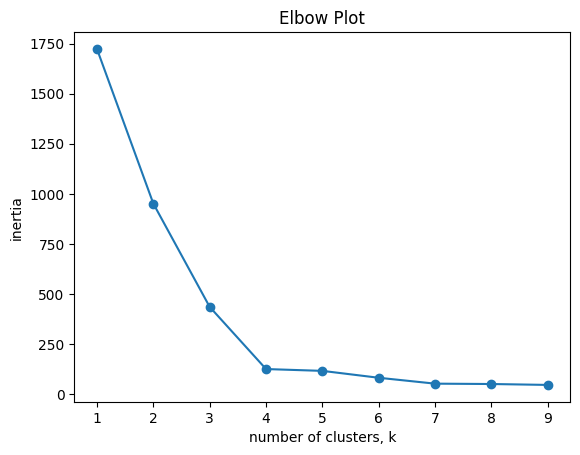

In [417]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(penguins_PCA)
    inertias.append(model.inertia_)
    
# Elbow Plot
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title("Elbow Plot")
plt.show()


The **elbow point** here is where `k = 4`. This is where the rate of decrease in inertia slows down significantly. This point indicates the optimal number of clusters because adding more clusters beyond this point yields diminishing returns in terms of reducing inertia.

### Running KMeans with the chosen n_clusters

In [418]:
n_clusters = 4

kmeans = KMeans(n_clusters = n_clusters, random_state=42)

kmeans.fit(penguins_PCA)

# Get cluster labels
labels = kmeans.labels_

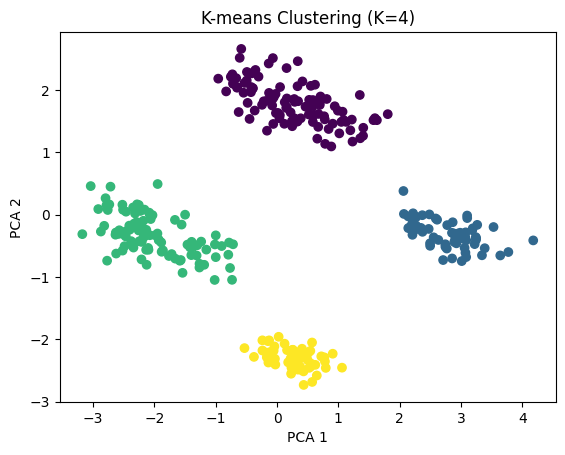

In [419]:
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'K-means Clustering (K={n_clusters})')
plt.show()

### Evaluating the quality of clustering results

+ **Silhouette Score** - measures how similar each sample is to its own cluster compared to other clusters. It ranges from -1 to +1, where:
   - `+1` indicates that the sample is very well matched to its own cluster and poorly matched to neighboring clusters.
   - `0` indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
   - `-1` indicates that the sample is misclassified, meaning it is likely in the wrong cluster.
+ **Davies-Bouldin Index** - measures the average similarity ratio of each cluster with the cluster that is most similar to it. It is based on intra-cluster distances (compactness) and inter-cluster distances (separation). The index ranges from 0 to ∞, where:
   - **Lower** values indicate better clustering, with clusters that are more compact and well-separated.
   - **Higher** values indicate worse clustering, where clusters are more similar to each other or less compact.

In [420]:
silhouette_avg = silhouette_score(penguins_PCA, labels)
davies_bouldin = davies_bouldin_score(penguins_PCA, labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.7421034438118217
Davies-Bouldin Index: 0.347761818349158


- A Silhouette Score of `0.742` is quite high, indicating that the clusters are well-separated and that samples are well-clustered.
- A Davies-Bouldin Index of 0.348 is low, indicating that clusters are well-separated and distinct.

### Cluster Analysis

In [421]:
# Get PCA components and their contribution to the principal components
components = pd.DataFrame(pca.components_, columns=column_names)
print(components)

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0          0.434281        -0.155607           0.479181     0.508436   
1         -0.096488         0.612380          -0.309139    -0.187765   

   sex_FEMALE  sex_MALE  
0   -0.386694  0.386694  
1   -0.492371  0.492371  


- Higher absolute values indicate that the feature contributes more to that principal component.

- `culmen_length_mm`, `flipper_length_mm`, `body_mass_g` have higher contributions in PC1, while `culmen_depth_mm` have higher contributions in PC2.

- Additionally, you can see that `sex_FEMALE` has a negative weight, and `sex_MALE` has a positive weight of similar magnitude. This suggests that the principal component is capturing the difference between female and male.

#### Cluster Profiles

In [422]:
# Add PCA components to df for analysis
new_penguins_df['PCA1'] = penguins_PCA[:, 0]
new_penguins_df['PCA2'] = penguins_PCA[:, 1]

# Add cluster labels to the df
new_penguins_df['label'] = labels

# Profile the clusters
stat_penguins = new_penguins_df.groupby(by='label')[column_names].mean()
print(stat_penguins)

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
label                                                                      
0             43.878302        19.111321         194.764151  4006.603774   
1             49.473770        15.718033         221.540984  5484.836066   
2             40.217757        17.611215         189.046729  3419.158879   
3             45.563793        14.237931         212.706897  4679.741379   

       sex_FEMALE  sex_MALE  
label                        
0             0.0       1.0  
1             0.0       1.0  
2             1.0       0.0  
3             1.0       0.0  


### Pairplot
+ `Kernel Density Estimation - KDE` (Diagonal Plots) - show the distribution of a single feature within each cluster where
     * the peaks indicate where the majority of data points lie for that feature within a cluster
        - Higher peaks indicate a higher density of data points around that value.
        - If the peaks are at different positions, it means the clusters have different characteristics for that feature.
     * the width of the KDE plot indicates how spread out the data points are
        - Narrow peaks mean that the data points are closely packed, while wider peaks mean more spread out data points.
+ `Scatter Plots` (Off-Diagonal Plot) - show the relationship between two different features, with points colored according to their cluster labels

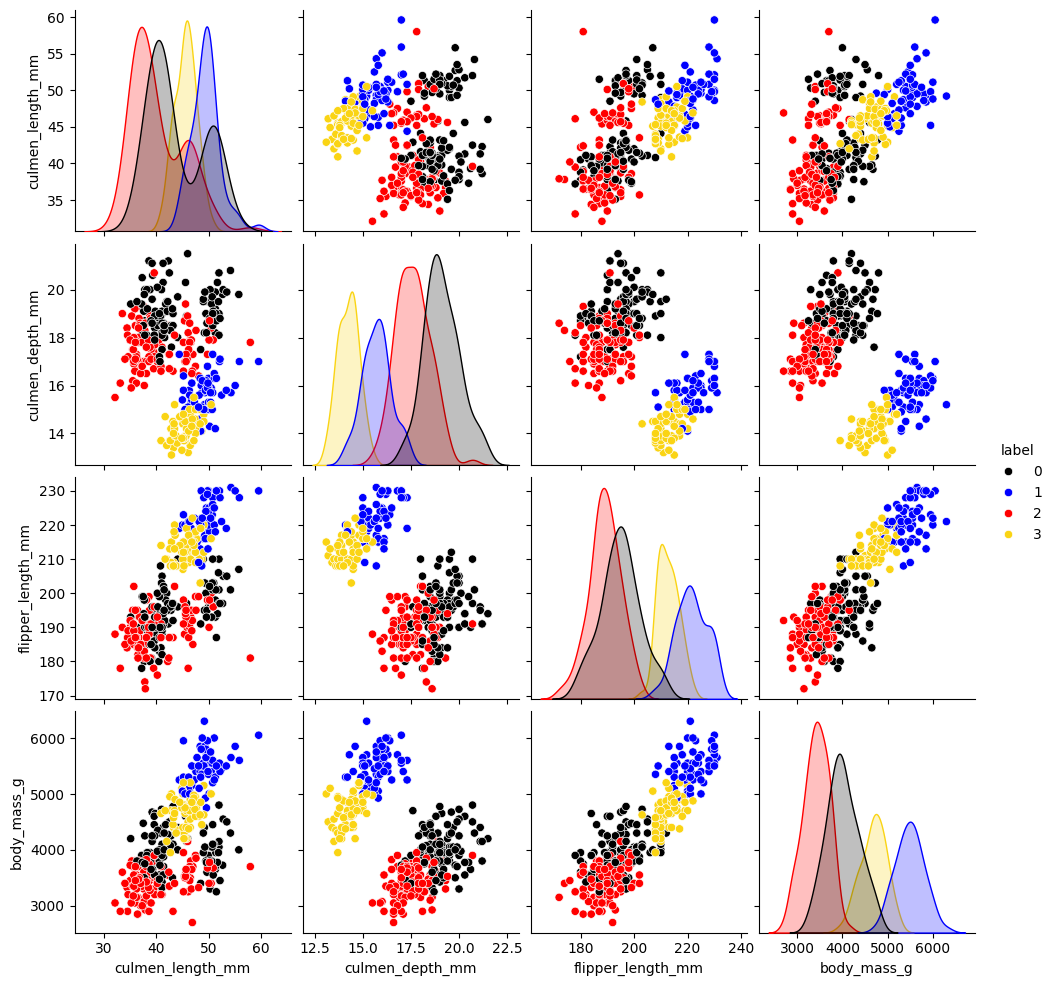

In [423]:
numeric_columns = column_names[:-2]

custom_palette = ['black', 'blue', 'red', '#fad414']

sns.pairplot(new_penguins_df, vars=numeric_columns, hue='label', palette=custom_palette)
plt.show()

**Cluster Characteristics:**

- `Cluster 0 [Black]` : High variability in all features, indicating a mixed group with diverse characteristics.
- `Cluster 1 [Blue]` : Narrow range in culmen length, broader in other features.
- `Cluster 2 [Red]` : Overlaps with the black cluster, suggesting similar characteristics.
- `Cluster 3 [Yellow]` : Distinct with higher body mass, flipper lengths, and lower culmen lengths and depths.

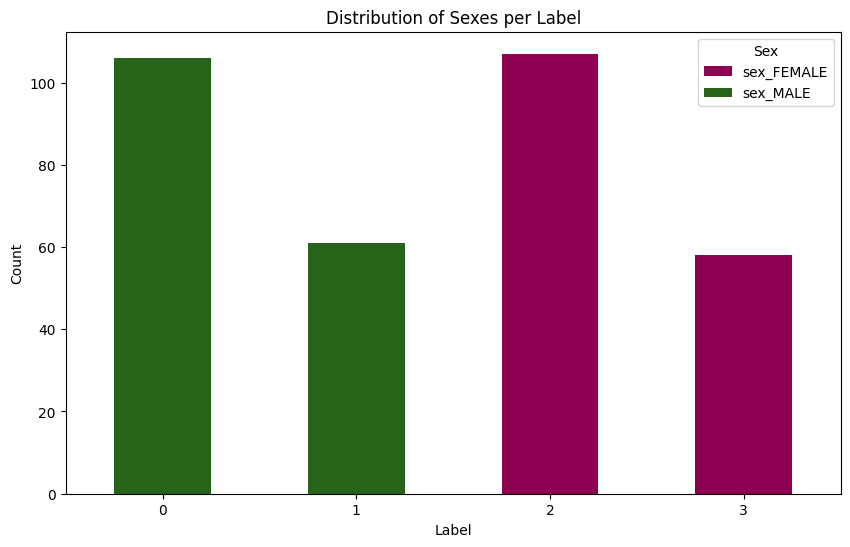

In [426]:
sex_cluster_df = new_penguins_df.groupby('label')[["sex_FEMALE","sex_MALE" ]].sum()
sex_cluster_df

sex_cluster_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='PiYG')
plt.title('Distribution of Sexes per Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=0)
plt.show()

The bar plot shows that `Clusters 0` and `1` consist of **males** and `Clusters 2` and `3` consist of **females**.